### Power System Load Type Prediction

#### Objective
The objective of this project is to develop a machine learning model that predicts the load type
(Light_Load, Medium_Load, Maximum_Load) of a power system using historical power consumption data.

#### Dataset
Historical power consumption data with temporal and electrical features.

#### Approach
- Time-aware train-test split (last month as test set)
- Median imputation for missing values
- Feature engineering using temporal and cyclical features
- Model comparison and hyperparameter tuning


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Loading the dataset
df = pd.read_csv("../data/load_data.csv")

In [ ]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%d-%m-%Y %H:%M')
df.head()


,Date_Time,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Load_Type
0,2018-01-01 00:15:00,8.753692,2.95,0.0,0.0,73.210000,100.0,900.000000,Light_Load
1,2018-01-01 00:30:00,4.000000,4.46,0.0,0.0,66.770000,100.0,1800.000000,Light_Load
2,2018-01-01 00:45:00,3.240000,3.28,0.0,0.0,70.280000,100.0,8070.880991,Light_Load
3,2018-01-01 01:00:00,3.310000,3.56,0.0,0.0,68.090000,100.0,3600.000000,Light_Load
4,2018-01-01 01:15:00,3.820000,4.50,0.0,0.0,133.655666,NaN,4500.000000,Light_Load


In [ ]:
# Displaying dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35041 entries, 0 to 35040
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date_Time                             35041 non-null  datetime64[ns]
 1   Usage_kWh                             33482 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  34165 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  33885 non-null  float64       
 4   CO2(tCO2)                             34586 non-null  float64       
 5   Lagging_Current_Power_Factor          34691 non-null  float64       
 6   Leading_Current_Power_Factor          33570 non-null  float64       
 7   NSM                                   34586 non-null  float64       
 8   Load_Type                             35041 non-null  object        
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 2.4+ MB


In [ ]:
df.describe()

,Date_Time,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35041,33482.000000,34165.000000,33885.000000,34586.000000,34691.000000,33570.000000,34586.000000
mean,2018-07-02 11:59:59.589052928,30.873061,14.704573,4.386097,0.012947,90.740871,94.926552,48013.664032
min,2018-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018-04-02 06:00:00,3.310000,2.340000,0.000000,0.000000,66.295000,99.800000,22500.000000
50%,2018-07-02 12:00:00,5.290000,5.180000,0.000000,0.000000,90.080000,100.000000,45000.000000
75%,2018-10-01 18:00:00,53.560000,23.510000,2.298558,0.020000,100.000000,100.000000,68400.000000
max,2018-12-31 23:45:00,435.019069,262.630718,78.809000,0.188166,299.996814,299.969494,248821.810465
std,NaN,41.415015,20.342721,9.090181,0.019726,39.745395,49.826872,34046.492333


In [ ]:
# Check missing values
df.isnull().sum()

Date_Time                                  0
Usage_kWh                               1559
Lagging_Current_Reactive.Power_kVarh     876
Leading_Current_Reactive_Power_kVarh    1156
CO2(tCO2)                                455
Lagging_Current_Power_Factor             350
Leading_Current_Power_Factor            1471
NSM                                      455
Load_Type                                  0
dtype: int64

##### Handling Missing Values

Several numerical features contain missing values.  
To preserve temporal continuity and avoid data leakage, median imputation is applied to numerical columns only.


In [ ]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('Load_Type', errors='ignore')

# Median imputation for all numerical features
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)


In [8]:
df.isnull().sum()

Date_Time                               0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
Load_Type                               0
dtype: int64

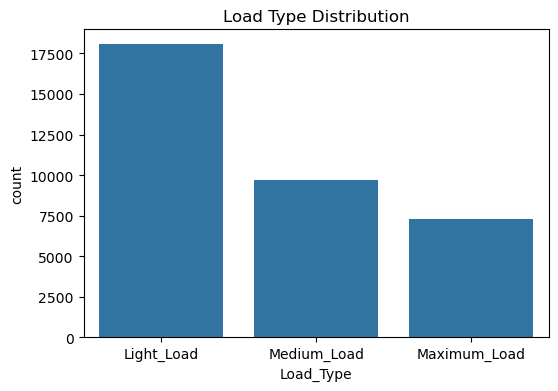

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='Load_Type', data=df)
plt.title("Load Type Distribution")
plt.show()

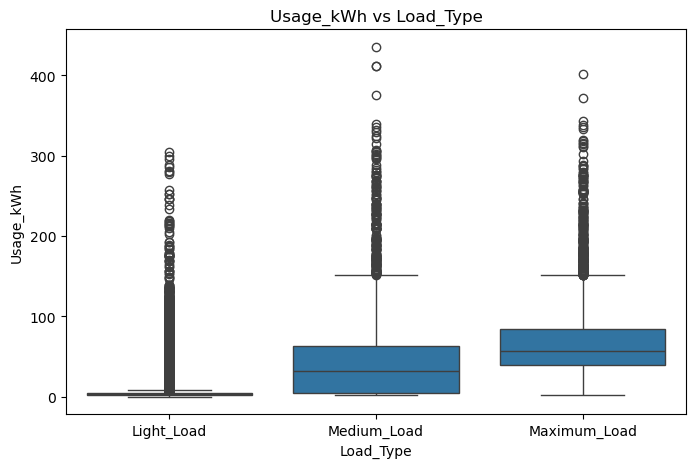

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Load_Type', y='Usage_kWh', data=df)
plt.title("Usage_kWh vs Load_Type")
plt.show()

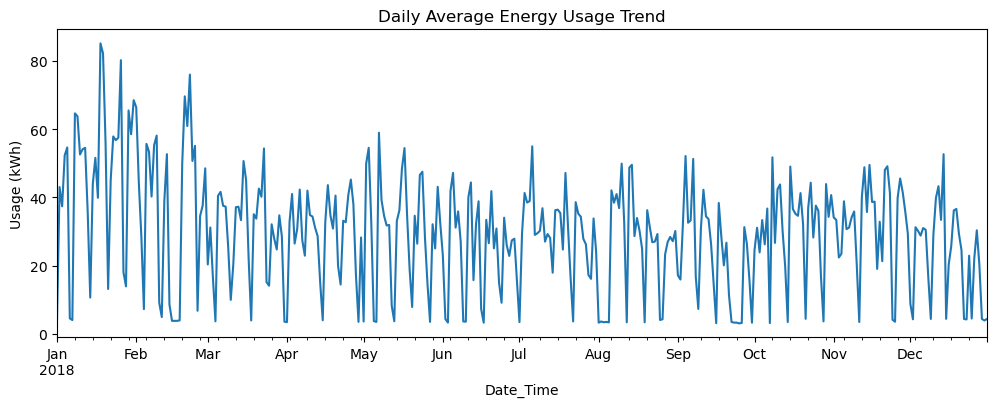

In [ ]:
# Time series plot of Usage_kWh over Date_Time
plt.figure(figsize=(12,4))
df.set_index('Date_Time')['Usage_kWh'].resample('D').mean().plot(figsize=(12,4))
plt.title("Daily Average Energy Usage Trend")
plt.ylabel("Usage (kWh)")
plt.show()

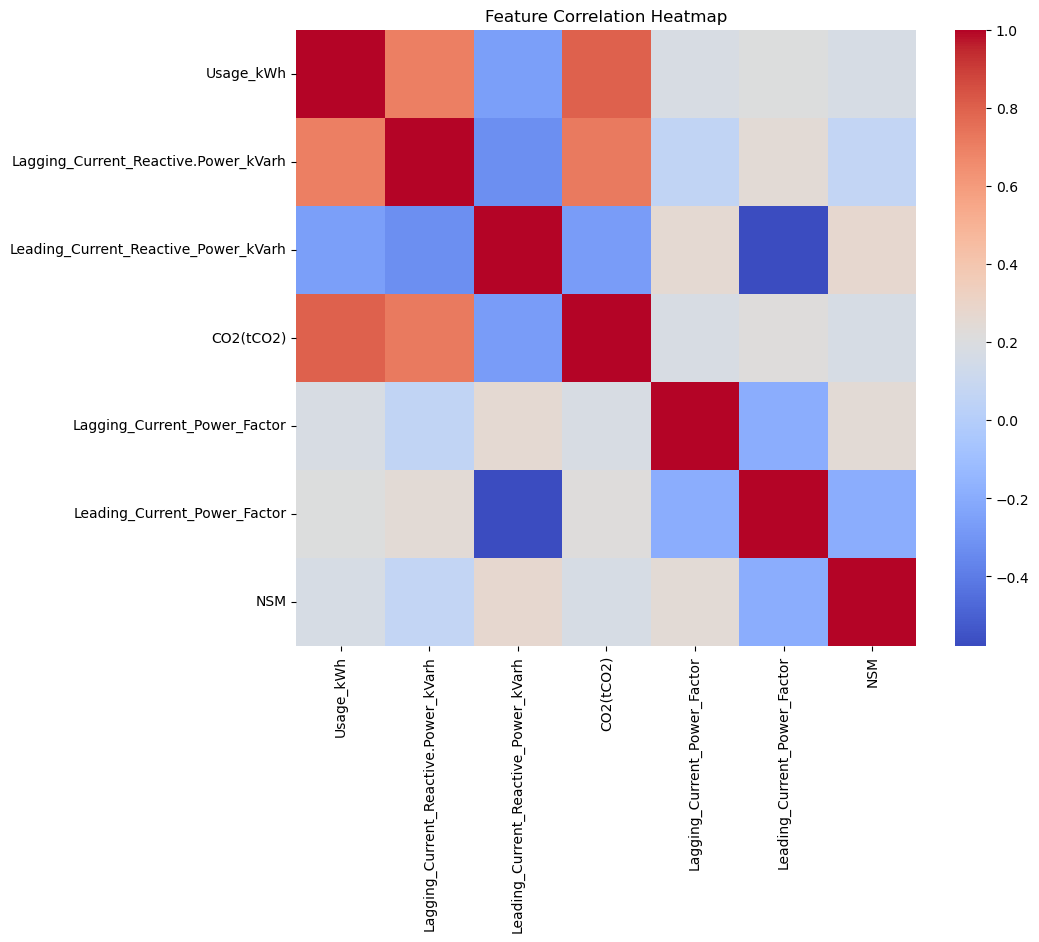

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[numerical_cols].corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Feature Engineering: Extracting Date-Time Features
df['Month'] = df['Date_Time'].dt.month
df['Hour'] = df['Date_Time'].dt.hour

In [ ]:
# Creating cyclical features for Hour of Day
df['NSM_sin'] = np.sin(2 * np.pi * df['NSM'] / 86400)
df['NSM_cos'] = np.cos(2 * np.pi * df['NSM'] / 86400)

In [ ]:
# Encoding Load_Type
le = LabelEncoder()
df['Load_Type_Encoded'] = le.fit_transform(df['Load_Type'])


In [16]:
df = df.sort_values('Date_Time')

last_month = df['Date_Time'].dt.to_period('M').max()
train_df = df[df['Date_Time'].dt.to_period('M') < last_month]
test_df  = df[df['Date_Time'].dt.to_period('M') == last_month]

X_train = train_df.drop(['Load_Type', 'Load_Type_Encoded', 'Date_Time'], axis=1)
y_train = train_df['Load_Type_Encoded']

X_test = test_df.drop(['Load_Type', 'Load_Type_Encoded', 'Date_Time'], axis=1)
y_test = test_df['Load_Type_Encoded']


In [ ]:
# Feature Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr.fit(X_train_scaled, y_train)

lr_preds = lr.predict(X_test_scaled)


In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)


In [ ]:
# Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

gb_preds = gb.predict(X_test)


In [21]:
def evaluate_model(y_true, y_pred, name):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))


In [ ]:
# Evaluating model performance
evaluate_model(y_test, lr_preds, "Logistic Regression")
evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, gb_preds, "Gradient Boosting")



Logistic Regression
Accuracy: 0.5824655693651327
Precision: 0.6842704484909714
Recall: 0.5824655693651327
F1 Score: 0.6191724067885808

Random Forest
Accuracy: 0.9217332885455156
Precision: 0.9302767774047783
Recall: 0.9217332885455156
F1 Score: 0.9229496785426144

Gradient Boosting
Accuracy: 0.8784010749076251
Precision: 0.900596588717305
Recall: 0.8784010749076251
F1 Score: 0.8808724029254844


#### FINAL MODEL SELECTION (UPDATED)

#### Random Forest is the Final Model

**Justification:**

Random Forest was selected as the final model because it achieved the highest overall performance among all evaluated models, with an accuracy of **92.17%** and a weighted F1-score of **92.29%**. These results indicate strong and balanced classification capability across all load categories (*Light_Load*, *Medium_Load*, and *Maximum_Load*).

The ensemble-based nature of Random Forest allows it to effectively capture complex, non-linear relationships between power consumption features and load conditions, which are common in real-world power system data. Additionally, Random Forest is robust to feature correlations and does not require strict feature scaling, making it well-suited for heterogeneous electrical and temporal features.

Due to its superior predictive performance, robustness, and practical applicability, Random Forest was chosen as the final model for this task.


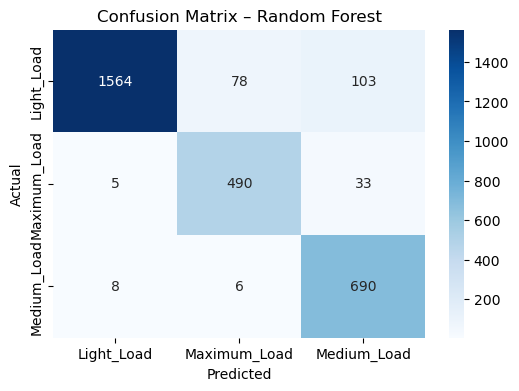

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, rf_preds)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()


In [24]:
importances = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances.head(10)


Hour                                    0.214800
NSM                                     0.184382
Month                                   0.130041
Usage_kWh                               0.105396
NSM_sin                                 0.083940
CO2(tCO2)                               0.073590
NSM_cos                                 0.070777
Lagging_Current_Power_Factor            0.043320
Leading_Current_Power_Factor            0.032007
Lagging_Current_Reactive.Power_kVarh    0.031304
dtype: float64

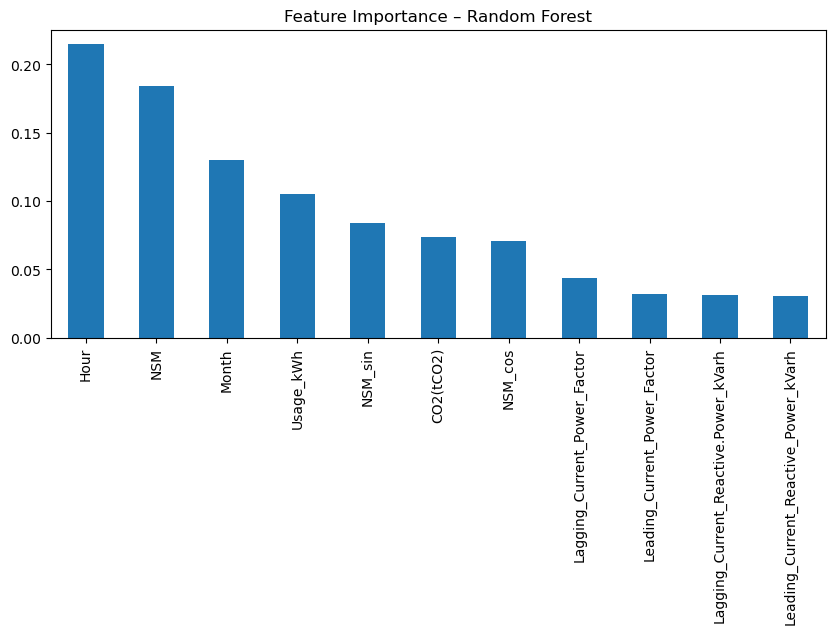

In [ ]:
importances.plot(kind='bar', figsize=(10,4))
plt.title("Feature Importance – Random Forest")
plt.show()